# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Calibrate
4. Calculate lattice vectors
5. Fit lattice vectors
6. **Calculate strain**
7. Visualize strain maps

# Notebook 6: Calculate strain

In this step the strain is calculated from the lattice vectors at each scan position, proceeding as follows:

* Specify a reference region
* Calculate the strain

Relevant mathematics can be found at the end of notebooks/module_demos/latticevectors/strain.ipynb.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from numpy.linalg import lstsq
from scipy.signal import medfilt

from py4DSTEM.file.datastructure import RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

from py4DSTEM.process.latticevectors import get_strain_from_reference_region

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    braggvectormap_shiftcorrected_ellipsecorrectedDiffractionSlice    
   2    braggvectormap_uncorrected          DiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffraction_shifts                  RealSlice           
   5    uv_map                              RealSlice           
   6    lattice_vectors                     PointList           
   7    braggpeaks                          PointListArray      
   8    braggpeaks_shifted_ellipticalcorrectedPointListArray      


In [3]:
# Load data

uv_map = browser.get_dataobject('uv_map')
browser.close()

### Specify a reference region 

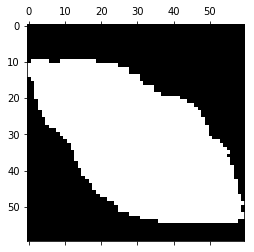

In [4]:
mask = uv_map.data['mask'].astype(bool)

fig,ax = plt.subplots()
ax.matshow(mask,cmap='gray')
plt.show()

### Calculate strain

In [5]:
# Calculate strain

strain_map = get_strain_from_reference_region(mask,uv_map)

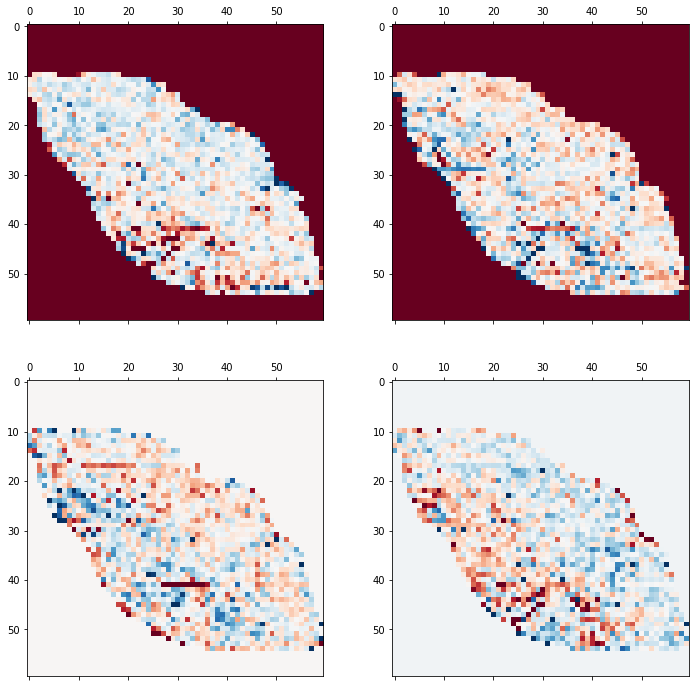

In [6]:
# Show

nstd = 2.5  # Sets display color range

# Set display color scales
e_xx_ave, e_xx_std = np.average(strain_map.data['e_xx'][mask]),np.std(strain_map.data['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_map.data['e_yy'][mask]),np.std(strain_map.data['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_map.data['e_xy'][mask]),np.std(strain_map.data['e_xy'][mask])
theta_ave, theta_std = np.average(strain_map.data['theta'][mask]),np.std(strain_map.data['theta'][mask])
e_xx_range = [e_xx_ave-nstd*e_xx_std,e_xx_ave+nstd*e_xx_std]
e_yy_range = [e_yy_ave-nstd*e_yy_std,e_yy_ave+nstd*e_yy_std]
e_xy_range = [e_xy_ave-nstd*e_xy_std,e_xy_ave+nstd*e_xy_std]
theta_range = [theta_ave-nstd*theta_std,theta_ave+nstd*theta_std]

# Plot
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,12))
ax11.matshow(strain_map.data['e_xx'],vmin=e_xx_range[0], vmax=e_xx_range[1], cmap="RdBu_r")
ax12.matshow(strain_map.data['e_yy'],vmin=e_yy_range[0], vmax=e_yy_range[1], cmap="RdBu_r")
ax21.matshow(strain_map.data['e_xy'],vmin=e_xy_range[0], vmax=e_xy_range[1], cmap="RdBu_r")
ax22.matshow(strain_map.data['theta'],vmin=theta_range[0], vmax=theta_range[1], cmap="RdBu_r")
plt.show()

### Save strain maps

In [7]:
# Append to processing file

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(strain_map, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
